In [ ]:
!pip install torch torchvision torchaudio
!pip install transformers[torch] -U
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 21.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_excel("gdrive/My Drive/Medical50.xlsx")

In [ ]:
df.head()

,Title,Case
0,"A Laceration that Needed a Proper Exam, Not an...",A woman presented to the emergency department ...
1,Syringe Swap During Regional Block: A Case of ...,A patient presented for open reduction and int...
2,Radiology Missed an Intracranial Bleed in a Le...,A 2-month-old boy was brought to the pediatric...
3,Myasthenia Crisis after a Delayed Diagnosis in...,A 9-year-old girl with cerebral palsy and epil...
4,"When Taking an SGLT2 inhibitor, Remember To SS...",A 67-year-old man with well-controlled type 2 ...


In [ ]:
df['formatted_text'] = df['Title'] + "\n\n" + df['Case'] + "\n<|endoftext|>\n"

In [ ]:
with open('processed_for_gpt2.txt', 'w', encoding='utf-8') as file:
    for item in df['formatted_text']:
        file.write(item)

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import tensorflow as tf

In [ ]:
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

In [ ]:
# Loading tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2',pad_token_id=tokenizer.eos_token_id)

In [ ]:
train_path = 'processed_for_gpt2.txt'
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=train_path,
    block_size=128)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [ ]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False)

In [ ]:
# Setting up the training arguments
training_args = TrainingArguments(
    output_dir="./gpt2_finetuned",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    save_steps=10_000,
    save_total_limit=2,
)

In [ ]:
# Initializing Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Step,Training Loss


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


TrainOutput(global_step=74, training_loss=3.473036482527449, metrics={'train_runtime': 759.5077, 'train_samples_per_second': 0.388, 'train_steps_per_second': 0.097, 'total_flos': 19270287360000.0, 'train_loss': 3.473036482527449, 'epoch': 1.0})

In [ ]:
def generate_text(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    max_length = len(input_text.split()) + 200  # Adjust generation length here
    output = model.generate(input_ids, max_length=max_length, num_beams=5, no_repeat_ngram_size=2, early_stopping=True,temperature=0.7)
    output_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return output_text

In [ ]:
def gr_interface():
    with gr.Blocks() as demo:
        gr.Markdown("### Generate Medical Text with GPT-2")
        input_text = gr.Textbox(label="Enter your medical query")
        output_text = gr.Textbox(label="GPT-2 Generated Text")
        generate_button = gr.Button("Generate")

        generate_button.click(
            fn=generate_text,
            inputs=input_text,
            outputs=output_text
        )

    return demo


In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

In [ ]:
# Launching the Gradio interface
demo = gr_interface()
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://729467043ef7192856.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
# Generating synthetic data
synthetic_data = {'Title': [], 'Synthetic Case': []}
for index, row in df.head(150).iterrows():
    generated_text = generate_text(row['Title'])
    synthetic_data['Title'].append(row['Title'])
    synthetic_data['Synthetic Case'].append(generated_text)

synthetic_df = pd.DataFrame(synthetic_data)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
synthetic_df.shape

(150, 2)

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')).union(STOPWORDS)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def generate_word_cloud(text_series, title):
    text = ' '.join(text_series)
    wordcloud = WordCloud(stopwords=stop_words, background_color='white', width=800, height=400).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

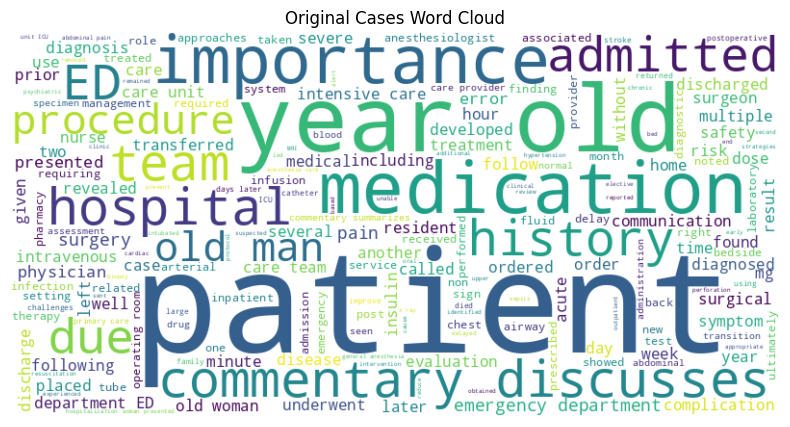

In [ ]:
generate_word_cloud(df['Case'].head(150), 'Original Cases Word Cloud')

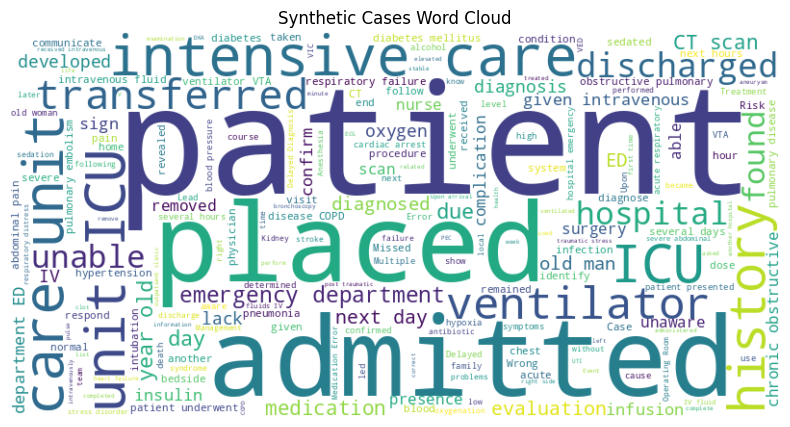

In [ ]:
generate_word_cloud(synthetic_df['Synthetic Case'], 'Synthetic Cases Word Cloud')

In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 1.4 MB/s eta 0:00:00


In [ ]:
from sacrebleu import corpus_bleu

In [ ]:
original_texts = df['Case'].head(150).tolist()
synthetic_texts = synthetic_df['Synthetic Case'].tolist()

In [ ]:
references = [[case] for case in original_texts]
system = [case for case in synthetic_texts]

In [ ]:
bleu_score = corpus_bleu(system, references)

In [ ]:
print(f"BLEU score: {bleu_score.score}")

BLEU score: 46.9175362368851
